# readme
descrip: plot regression (SSH AMOC Time Series) for Sunway LR and HR (transient (TR) minus control (CN)) <br>

update history: <br>
v1.0 DL 2021Feb06 <br>
v1.1 DL 2021Mar03 <br>
v1.2 DL 2021Apr24 <br>
v1.3 DL 2021May06 make publication-ready pics <br>
v1.4 DL 2021May20 combine TR run results into one fig (for main text) and control run results into one fig (support info) <br>
v1.5 DL 2021Jun02 pivot to CESM-HR special volume paper, use TR minus CN to account for the model drift <br>
 
extra notes: <br>
AMOC-DSL scaling (Little et al., 2019) <br>
$ \rho_0 \frac{h_w}{Q}  = -  \frac{f}{g H_e}$ <br>
Reference: Little et al., (2019) Eq(1-6) <br>

# import modules

In [1]:
# general python packages
import numpy as np
from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
# import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid

# python GCM(POP) packages
# import xgcm
# import pop_tools
# import xoak
# import xesmf as xe
import seawater as sw 

# dask jupyter lab packages
# from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
# client = Client("tcp://10.73.2.193:37188")
# client

# define parameters

In [3]:
# # === Gulf of Maine (GMa) ===
# lat1_GMa, lat2_GMa = 25, 55
# lon1_GMa, lon2_GMa = -85, -50 # GMa: Gulf of Maine

# lon1b_GMa, lon2b_GMa = -71+360, -66+360  # b: box, highlight region with a box 
# lat1b_GMa, lat2b_GMa = 42, 45
# # ===========================

# # === Gulf of Maxico (GMe) ===
# lat1_GMe, lat2_GMe = 15, 35
# lon1_GMe, lon2_GMe = -100, -75 # GMe: Gulf of Mexico

# lon1b_GMe, lon2b_GMe = -95+360, -85+360 # b: box, highlight region with a box 
# lat1b_GMe, lat2b_GMe = 23, 28
# # ============================

# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb
nlon1_r_t12, nlon2_r_t12 = 200, 700 
nlat1_r_t12, nlat2_r_t12 = 1300, 2000

nlon1_r_g16, nlon2_r_g16 = 260, 321
nlat1_r_g16, nlat2_r_g16 = 230, 350

lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55

# box1 (bx1), southeast US coast box
lon1_bx1, lon2_bx1 = -82, -79
lat1_bx1, lat2_bx1 = 30, 33
# box2 (bx2), northeast US coast box
lon1_bx2, lon2_bx2 = -71, -68
lat1_bx2, lat2_bx2 = 40.5, 43.5
# ===========================================================

time2 = np.arange(2001.5,2100.5+1) # 2001-2100 time period 2
time_en = np.arange(1850,2100+1,1) # 1850-2100 entire time period

chunks_HR = {'nlat':400,'nlon':300}
chunks_LR = {'nlat':384,'nlon':320}

In [4]:
# === AMOC files ===
indir = '/ihesp/archive/Sunway_Runs/'
# --- TH (transient HR), CH (control HR) ---
infile_MOC_CH=indir+'HR_PI_CTRL/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.MOC.002101.050112.nc'
infile_MOC_TH=indir+'HR_HF_TNST/B.E.13.BTRANS.ne120_t12.sehires38.003.sunway.pop.h.MOC.185001.210012.nc'
# infile_MHT_HR = '/ihesp/shared/HR_OMIP2-CMIP6/g.e20.G.TL319_t13.control.001.pop.h.012301-018312.N_HEAT.nc' # Meridional Heat Transport
# -----------------------------------------

# --- TL (transient LR), CL (control LR) ---
infile_MOC_TL=indir+'LR_HF_TNST/B.E.13.BTRANS.ne30g16.sehires38.003.sunway.pop.h.MOC.185001.210012.nc'
infile_MOC_CL=indir+'LR_PI_CTRL/B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.MOC.000101.050012.nc'
# ------------------------------------------
# ==================

# === POP grids files ===
infile_g16 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
# =======================

outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir+'AMOCDepthProfCESM_2021Sep07.png' # main text fig

# load files

In [5]:
ds_MOC_TL = xr.open_dataset(infile_MOC_TL)
time_s_TL = ds_MOC_TL.time.to_pandas().index.shift(-1,'M') 
ds_MOC_TL = ds_MOC_TL.assign_coords(time=time_s_TL)
ds_MOC_TL

<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, time: 3012, transport_reg: 2)
Coordinates:
  * time            (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp) |S256 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-11 at 22:22:40.9
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  750
    tavg_sum:      2592000.0

In [6]:
ds_MOC_CL = xr.open_dataset(infile_MOC_CL)
print(ds_MOC_CL.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
time_MOC_CL = xr.cftime_range(start="1601-01", end="2101-01", freq='M', calendar='noleap')
ds_MOC_CL = ds_MOC_CL.assign_coords(time=time_MOC_CL)
ds_MOC_CL

<xarray.DataArray 'time' (time: 6000)>
array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(500, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(500, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(501, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0501-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:         (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nchar: 256, time: 6000, transport_reg: 2)
Coordinates:
  * time            (time) object 1601-01-31 00:00:00 ... 2100-12-31 00:00:00
  * lat_aux_grid    (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
  * moc_z           (moc_z) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: d2, moc_comp, nchar, transport_reg
Data variables:
    time_bound      (time, d2) object ...
    moc_components  (moc_comp, nchar) |S1 ...
    MOC             (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
Attributes:
    title:           B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-12 at 12:53:17.5
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    750
    tavg_sum:        2592000.0
    tavg_sum_qflux:  2592000.0

In [7]:
ds_MOC_TH = xr.open_dataset(infile_MOC_TH)
time_s_TH = ds_MOC_TH.time.to_pandas().index.shift(-1,'M') # shift 1 mon
ds_MOC_TH = ds_MOC_TH.assign_coords(time=time_s_TH)
ds_MOC_TH

<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 3012, transport_reg: 2)
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

In [8]:
ds_MOC_CH = xr.open_dataset(infile_MOC_CH)
print(ds_MOC_CH.time)
# 250-->1850, 500-->2100
# 1-->1601, # 1850-(250-1)=1601
# 21-->1621,  501-->2101, 1850-(250-21)=1621
time_MOC_CH = xr.cftime_range(start="1621-01", end="2102-01", freq='M', calendar='noleap') 
ds_MOC_CH = ds_MOC_CH.assign_coords(time=time_MOC_CH)
ds_MOC_CH

<xarray.DataArray 'time' (time: 5772)>
array([cftime.DatetimeNoLeap(21, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(21, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(21, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(501, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(501, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(502, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0021-02-01 00:00:00 ... 0502-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


<xarray.Dataset>
Dimensions:            (lat_aux_grid: 395, moc_comp: 1, moc_z: 63, time: 5772, transport_reg: 2)
Coordinates:
  * time               (time) object 1621-01-31 00:00:00 ... 2101-12-31 00:00:00
    transport_regions  (transport_reg) |S256 ...
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: moc_comp, transport_reg
Data variables:
    MOC                (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...

In [9]:
# MOC45_yr_TL = (ds_MOC_TL.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
#     method='nearest').sel(moc_comp=0, transport_reg=1, time=slice('2001','2100')).resample(time='A').mean('time'))
# MOC45_yr_TH = (ds_MOC_TH.MOC.sel(lat_aux_grid=45, moc_z=1000*100,
#     method='nearest').sel(moc_comp=0, transport_reg=1, time=slice('2001','2100')).resample(time='A').mean('time'))
# MOC45_yr_TH

# MOC45_yr_CL = (ds_MOC_CL.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
#     moc_comp=0, transport_reg=1).sel(time=slice('2001','2100')).resample(time='A').mean('time'))
# MOC45_yr_CH = (ds_MOC_CH.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
#     moc_comp=0, transport_reg=1).sel(time=slice('2001','2100')).resample(time='A').mean('time'))

In [10]:
AMOC_CL = ds_MOC_CL.MOC.sel(moc_comp=0, transport_reg=1).sel(time=slice('1850','2100'))
AMOC_CH = ds_MOC_CH.MOC.sel(moc_comp=0, transport_reg=1).sel(time=slice('1850','2100'))
AMOC_CH

<xarray.DataArray 'MOC' (time: 3012, moc_z: 63, lat_aux_grid: 395)>
[74953620 values with dtype=float32]
Coordinates:
  * time               (time) object 1850-01-31 00:00:00 ... 2100-12-31 00:00:00
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Attributes:
    units:      Sverdrups
    long_name:  Meridional Overturning Circulation

In [11]:
AMOC_tav_CL = AMOC_CL.sel(time=slice('2001','2100')).mean('time')
AMOC_tav_CH = AMOC_CH.sel(time=slice('2001','2100')).mean('time')
AMOC_tav_CH

<xarray.DataArray 'MOC' (moc_z: 63, lat_aux_grid: 395)>
array([[1.4926391e+00, 1.4926391e+00, 1.4926391e+00, ..., 1.4915165e+00,
        1.4915138e+00, 1.4915124e+00],
       [2.4808779e+00, 2.4808779e+00, 2.4808779e+00, ..., 1.1522593e+00,
        1.1528368e+00, 1.1516854e+00],
       [3.4185381e+00, 3.4185381e+00, 3.4185381e+00, ..., 8.0797088e-01,
        8.0788100e-01, 8.0559629e-01],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.0789298e-08,
        3.0789298e-08, 3.0789298e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.0996404e-08,
        3.0996404e-08, 3.0996404e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    moc_components     |S256 b'Eulerian Mean'
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.75e+05 6e+05
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0

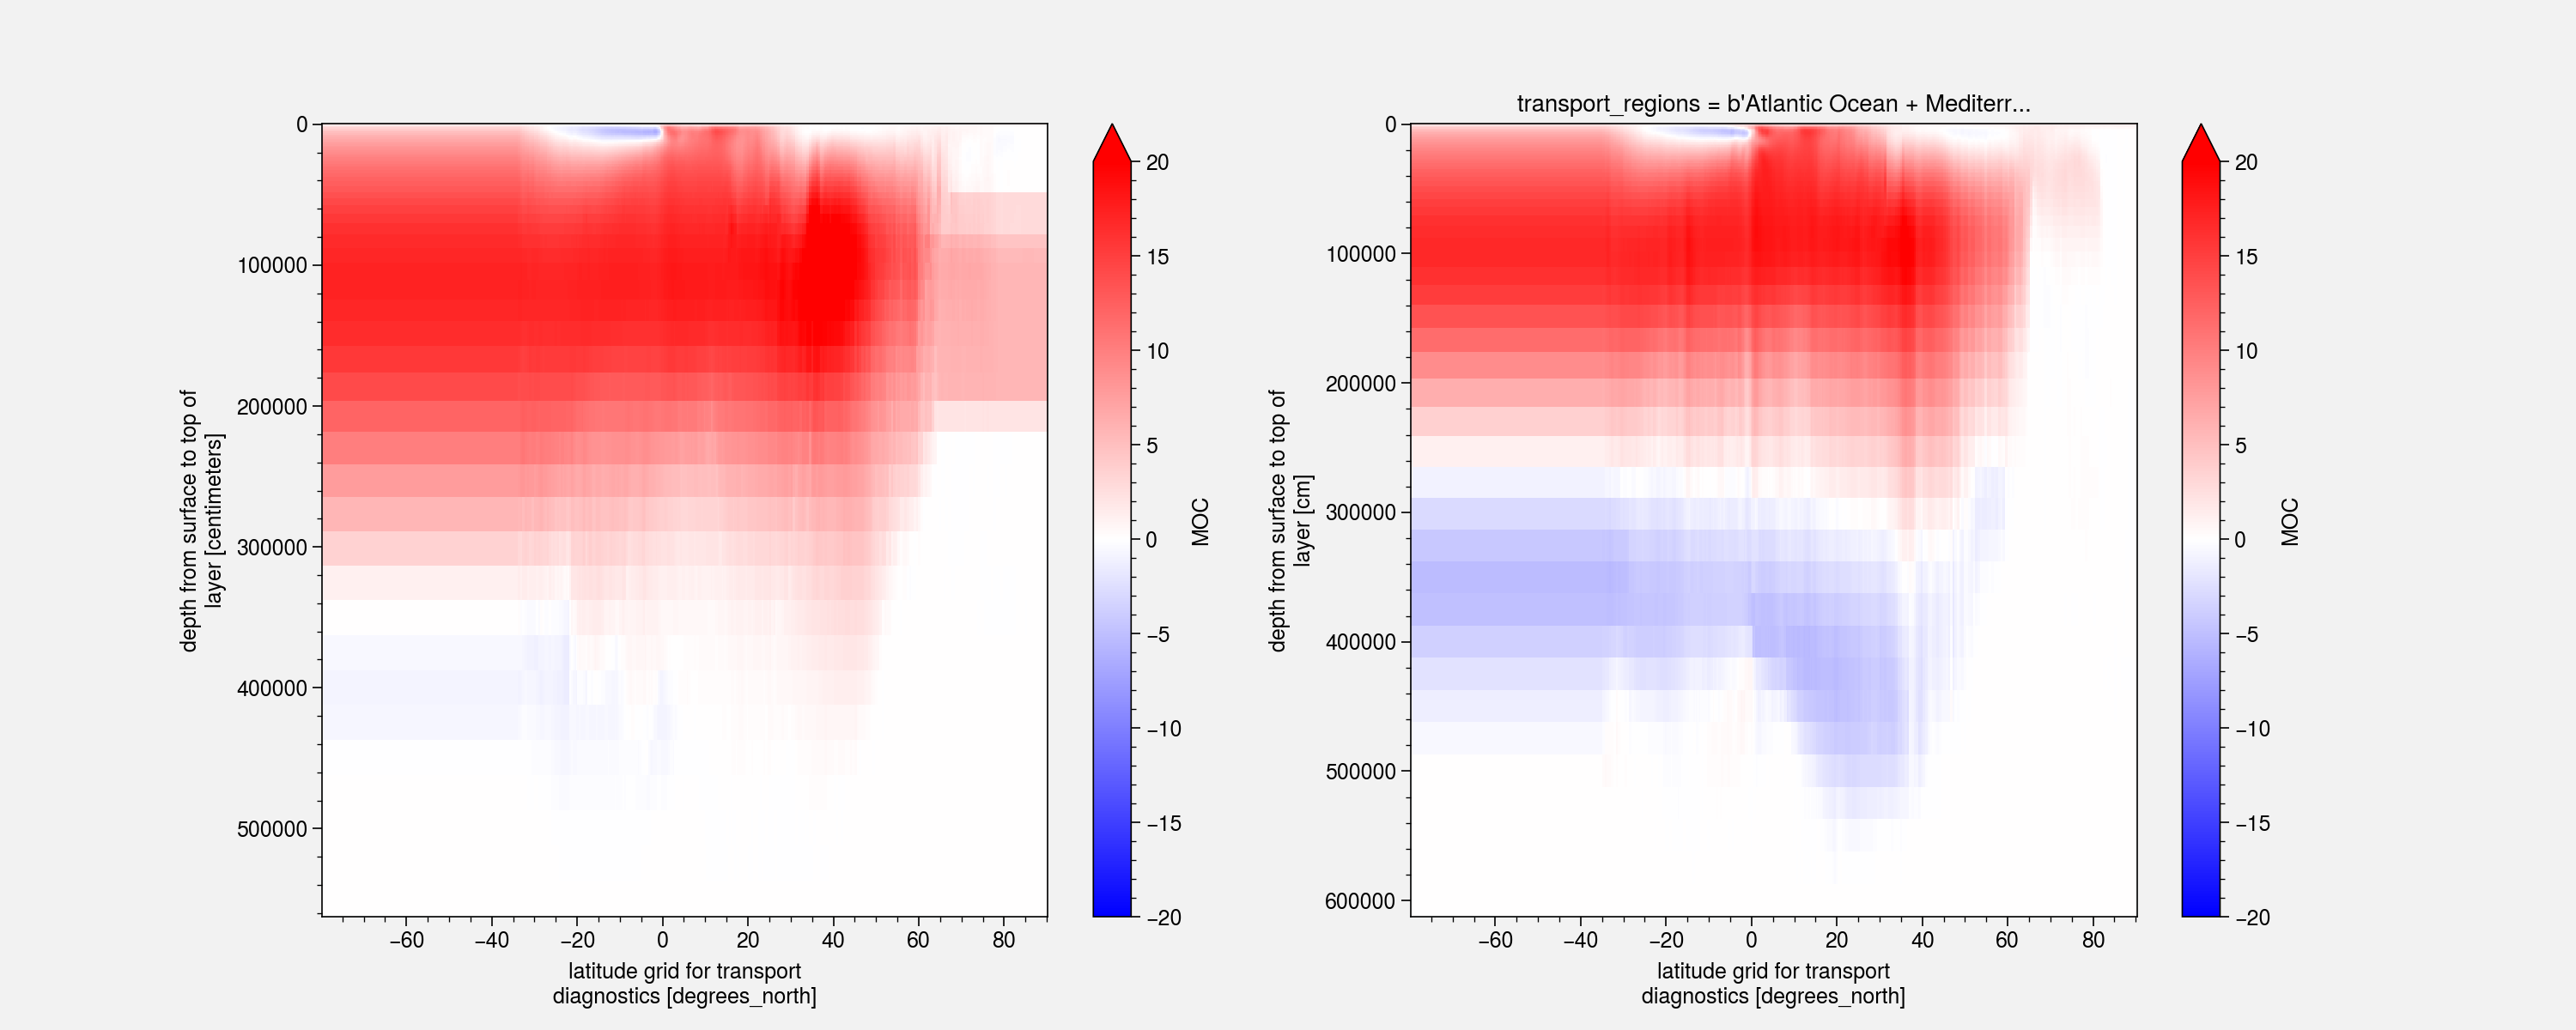

In [12]:
# Fig: mean AMOC stream function contours
fig, axs = plt.subplots(1,2,figsize=(15,6))

AMOC_tav_CL.plot(ax=axs[0], yincrease=False, vmin=-20, vmax=20, cmap='bwr')
AMOC_tav_CH.plot(ax=axs[1], yincrease=False, vmin=-20, vmax=20, cmap='bwr')

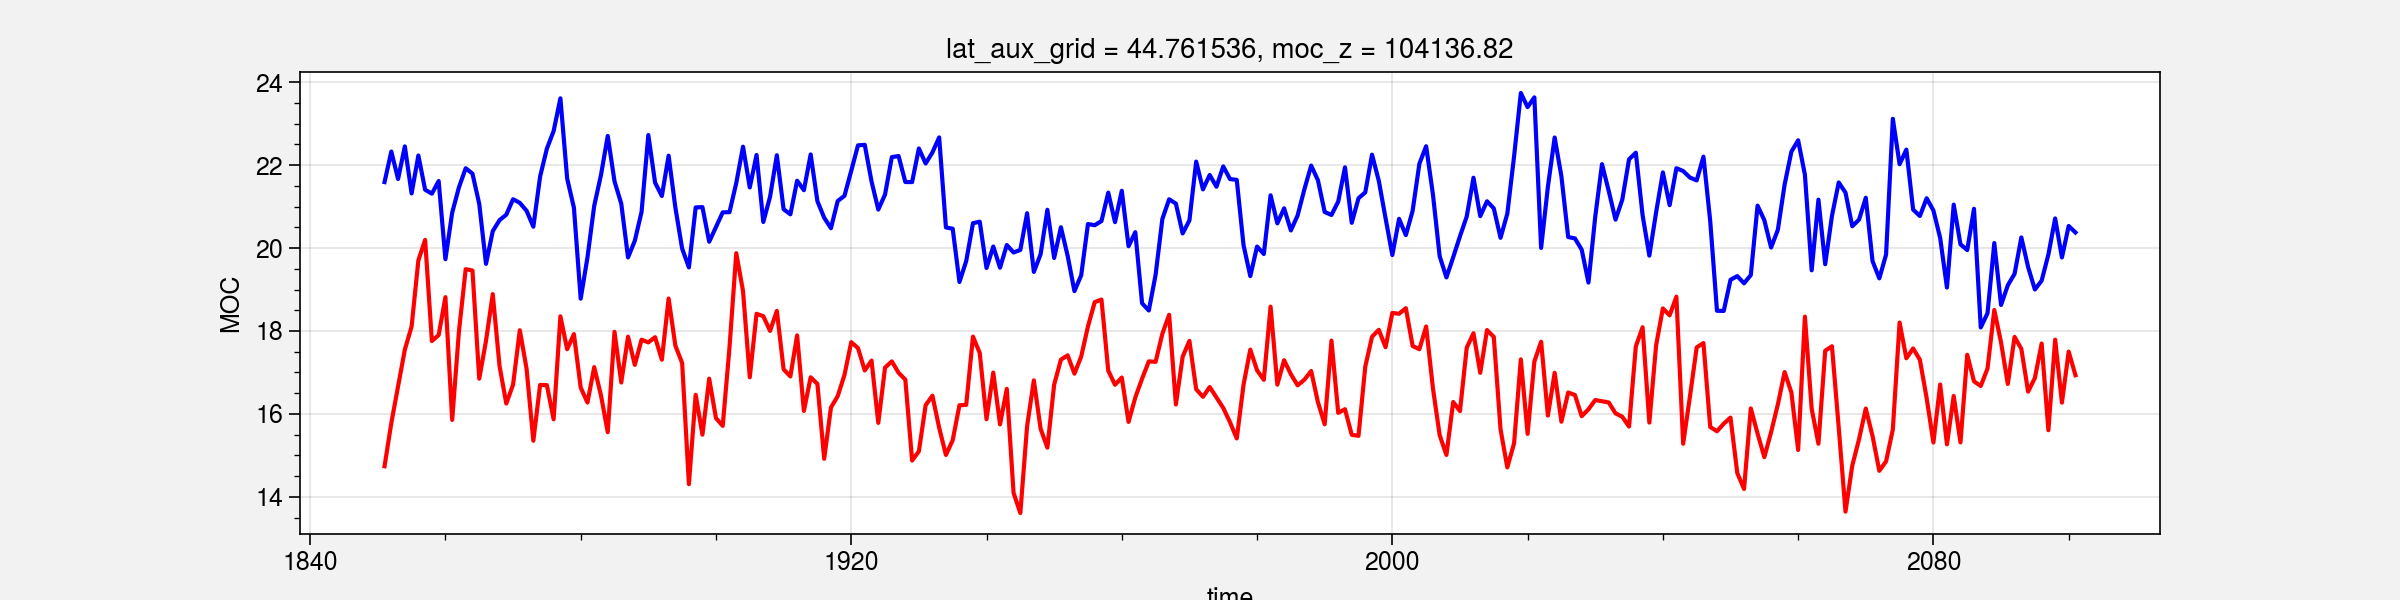

In [13]:
# Fig: AMOC index 
AMOC_45N1000m_CL = ds_MOC_CL.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
                             moc_comp=0, transport_reg=1, time=slice('1850','2100')).resample(time='A').mean('time')
AMOC_45N1000m_CH = ds_MOC_CH.MOC.sel(lat_aux_grid=45, moc_z=1000*100, method='nearest').sel(
                             moc_comp=0, transport_reg=1, time=slice('1850','2100')).resample(time='A').mean('time')

# AMOC_30N1400m_CL = ds_MOC_CL.MOC.sel(moc_comp=0, transport_reg=1).sel(
#                    lat_aux_grid=30,moc_z=1500*100,method='nearest').resample(time='A').mean('time')
# AMOC_30N1000m_CH = ds_MOC_CH.MOC.sel(moc_comp=0, transport_reg=1).sel(
#                    lat_aux_grid=30,moc_z=1000*100,method='nearest').resample(time='A').mean('time')


fig, axs = plt.subplots(1,1,figsize=(12,3))
AMOC_45N1000m_CH.plot(ax=axs, color='r')
AMOC_45N1000m_CL.plot(ax=axs, color='b')
# AMOC_30N1000m_CH.plot(color='r')
# AMOC_30N1400m_CL.plot(color='b')

(<matplotlib.lines.Line2D at 0x2b73fc088910>,)

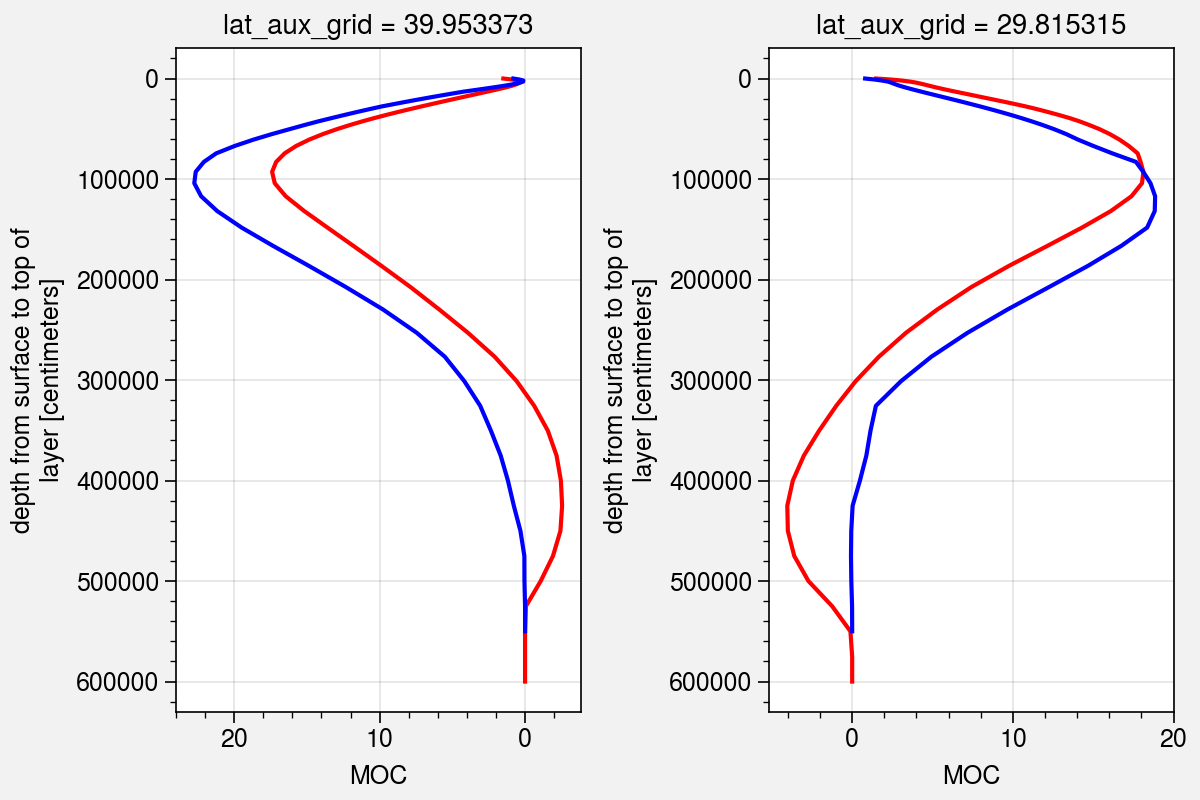

In [14]:
# Fig: AMOC depth profile
fig1, axs = plot.subplots(nrows=1,ncols=2,width='6in',height='4in',share=0)
AMOC_tav_CH.sel(lat_aux_grid=40, method='nearest').plot(ax=axs[0], y='moc_z',yincrease=False,color='r')
AMOC_tav_CL.sel(lat_aux_grid=40, method='nearest').plot(ax=axs[0], y='moc_z',yincrease=False,color='b')

AMOC_tav_CH.sel(lat_aux_grid=30, method='nearest').plot(ax=axs[1], y='moc_z',yincrease=False,color='r')
AMOC_tav_CL.sel(lat_aux_grid=30, method='nearest').plot(ax=axs[1], y='moc_z',yincrease=False,color='b')

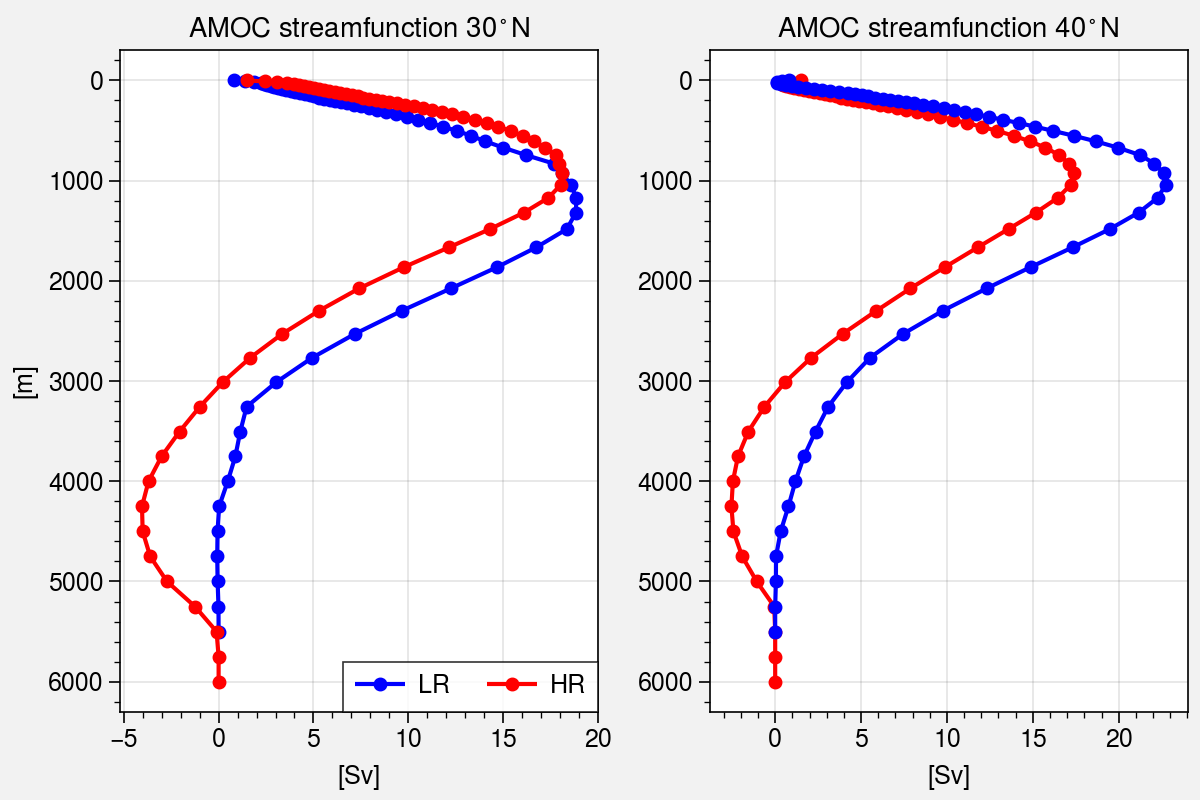

In [15]:
fig1, axs = plot.subplots(nrows=1,ncols=2,width='6in',height='4in',share=0)

axs[0].plot(AMOC_tav_CL.sel(lat_aux_grid=30, method='nearest'), 
            AMOC_tav_CL.sel(lat_aux_grid=30, method='nearest').moc_z/100, marker='o',markersize=4, color='b', label='LR')
axs[0].plot(AMOC_tav_CH.sel(lat_aux_grid=30, method='nearest'), 
            AMOC_tav_CH.sel(lat_aux_grid=30, method='nearest').moc_z/100, marker='o',markersize=4, color='r', label='HR')
axs[0].legend(loc='lr')
axs[0].invert_yaxis()
axs[0].set_xlabel('[Sv]')
axs[0].set_ylabel('[m]')
axs[0].set_title('AMOC streamfunction 30$^\circ$N')
# axs[0].invert_xaxis()

axs[1].plot(AMOC_tav_CH.sel(lat_aux_grid=40, method='nearest'), 
            AMOC_tav_CH.sel(lat_aux_grid=40, method='nearest').moc_z/100, marker='o', markersize=4, color='r')
axs[1].plot(AMOC_tav_CL.sel(lat_aux_grid=40, method='nearest'), 
            AMOC_tav_CL.sel(lat_aux_grid=40, method='nearest').moc_z/100, marker='o', markersize=4, color='b')
axs[1].invert_yaxis()
axs[1].invert_xaxis()
axs[1].set_xlabel('[Sv]')
axs[1].set_ylabel('')
axs[1].set_title('AMOC streamfunction 40$^\circ$N')

fig1.savefig(pic1,bbox_inches='tight')

In [16]:
# compute statistics for AMOC-DSL scaling (Little et al., 2019)
He30N_LR, He30N_HR = 1400, 1000 # He: effective layer thickness, unit [m]
He40N_LR, He40N_HR = 1000, 1000 

print('DSL-AMOC scaling at 30N for LR: [cm/Sv]', sw.f(30)/10/He30N_LR*1e8, '-', sw.f(30)/10/He30N_LR*1e8*2)
print('DSL-AMOC scaling at 30N for HR: [cm/Sv]', sw.f(30)/10/He30N_HR*1e8, '-', sw.f(30)/10/He30N_HR*1e8*2)
print('DSL-AMOC scaling at 40N for LR: [cm/Sv]', sw.f(40)/10/He40N_LR*1e8, '-', sw.f(40)/10/He40N_LR*1e8*2)
print('DSL-AMOC scaling at 40N for HR: [cm/Sv]', sw.f(40)/10/He40N_HR*1e8, '-', sw.f(40)/10/He40N_HR*1e8*2)

DSL-AMOC scaling at 30N for LR: [cm/Sv] 0.5208571428571428 - 1.0417142857142856
DSL-AMOC scaling at 30N for HR: [cm/Sv] 0.7292 - 1.4584
DSL-AMOC scaling at 40N for LR: [cm/Sv] 0.9374414499668487 - 1.8748828999336975
DSL-AMOC scaling at 40N for HR: [cm/Sv] 0.9374414499668487 - 1.8748828999336975


# Appendix